In [1]:
from sqlalchemy import create_engine
import pandas as pd
import geopandas as gpd
import psycopg2
from psycopg2 import sql
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
import os

# move current directory to /Users/tanyatsui/Documents/01_Projects/housingEmissions
os.chdir('/Users/tanyatsui/Documents/01_Projects/housingEmissions')

In [2]:
# create a connection to the database
db_name = 'urbanmining'
db_user = 'postgres'
db_password = 'Tunacompany5694!'
db_host = 'localhost'
db_port = '5432'
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')


# Data

In [77]:
# s0 - emissions_all_buurt 
query = ''' 
WITH bu_stats_raw AS (
	SELECT bu_code, population, n_homes, embodied_kg,
		embodied_kg / n_homes AS embodied_per_home, 
		operational_kg / n_homes AS operational_per_home
	FROM emissions_all_buurt
	WHERE n_homes > 0 AND population > 0 
), 
bu_stats AS (
	SELECT bu_code, 
    	AVG(embodied_kg) AS embodied_kg,
		AVG(embodied_per_home) AS embodied_per_home, 
		AVG(operational_per_home) AS operational_per_home, 
        AVG(n_homes) AS n_homes
	FROM bu_stats_raw 
	GROUP BY bu_code 
), 
bu_geoms AS (
	SELECT "BU_CODE" AS bu_code, "WK_CODE" AS wk_code, "GM_NAAM" AS municipality, 
		geometry AS bu_geom 
	FROM cbs_map_2022 
    WHERE "WATER" = 'NEE' 
)

SELECT a.*, b.bu_geom
FROM bu_stats a 
FULL JOIN bu_geoms b 
ON a.bu_code = b.bu_code 
'''

gdf_s0 = gpd.read_postgis(query, engine, geom_col='bu_geom')

In [78]:
# s3 - emissions_all_buurt_s3
query = f''' 
WITH scenario_stats_raw AS (
	SELECT 
		municipality, bu_code, 
        AVG(embodied_kg_s0) AS embodied_kg, 
        AVG(embodied_kg_s0 / n_homes) AS embodied_per_home,
        AVG(operational_kg_s0 / n_homes) AS operational_per_home, 
        AVG(n_homes) AS n_homes
	FROM emissions_all_buurt_s3 
	WHERE n_homes > 0 AND population > 0 
	GROUP BY municipality, bu_code 
), 
bu_geoms AS (
	SELECT "BU_CODE" AS bu_code, geometry AS bu_geom
	FROM cbs_map_2022
	WHERE "WATER" = 'NEE'
), 
scenario_stats_with_bu_geoms AS (
	SELECT 
		a.municipality, b.bu_code, b.bu_geom, a.embodied_kg,
		a.embodied_per_home, a.operational_per_home, a.n_homes
	FROM scenario_stats_raw a 
	FULL JOIN bu_geoms b 
	ON a.bu_code = b.bu_code
)
SELECT * FROM scenario_stats_with_bu_geoms
'''

gdf_s3 = gpd.read_postgis(query, engine, geom_col='bu_geom')

# Finding differences

In [82]:
s0 = gdf_s0[['bu_code', 'embodied_kg', 'n_homes', 'embodied_per_home']].rename(columns={'bu_code': 'bu_code_s0'})
s0 = s0[~s0.bu_code_s0.isnull()]
s3 = gdf_s3[['bu_code', 'embodied_kg', 'n_homes', 'embodied_per_home']].rename(columns={'bu_code': 'bu_code_s3'})
s3 = s3[~s3.bu_code_s3.isnull()]
s3 = s3[~s3.embodied_per_home.isnull()]

merged = s0.merge(s3, left_on='bu_code_s0', right_on='bu_code_s3', suffixes=('_s0', '_s3'), how='outer')
mismatched = merged[merged.embodied_per_home_s0 != merged.embodied_per_home_s3]
print(f'{round(len(mismatched)/len(merged)*100, 2)}% of records are are mismatched for operational and embodied emissions per home')
mismatched = merged[merged.n_homes_s0 != merged.n_homes_s3]
print(f'{round(len(mismatched)/len(merged)*100, 2)}% of records are are mismatched for n homes')

mismatched


94.2% of records are are mismatched for operational and embodied emissions per home
99.15% of records are are mismatched for n homes


,bu_code_s0,embodied_kg_s0,n_homes_s0,embodied_per_home_s0,bu_code_s3,embodied_kg_s3,n_homes_s3,embodied_per_home_s3
0,BU00140000,829157.3,2029.0,392.919548,BU00140000,829157.3,1622742.3,0.484893
1,BU00140001,1208135.1,3297.9,356.043543,BU00140001,1208135.1,3770656.5,0.309788
2,BU00140002,867952.1,2198.4,383.575109,BU00140002,867952.1,1713468.3,0.489529
3,BU00140003,396215.0,880.4,452.357239,BU00140003,396215.0,224186.4,1.747062
4,BU00140005,1356177.5,2561.7,496.748111,BU00140005,1356177.5,2746071.4,0.449650
...,...,...,...,...,...,...,...,...
13818,BU19910603,108009.2,169.6,631.154160,BU19910603,108009.2,27099.8,3.866005
13819,BU19910604,35010.5,130.0,267.620706,BU19910604,35010.5,16408.4,2.098321
13820,BU19910605,113198.2,72.6,1526.929789,BU19910605,113198.2,5344.5,20.212526
13821,BU19910606,52267.1,96.2,542.894083,BU19910606,52267.1,8496.4,6.084463


In [57]:
gdf_s0.columns

Index(['bu_code', 'total_kg_per_capita', 'total_kg_per_home',
       'embodied_per_home', 'operational_per_home', 'embodied_kg',
       'operational_kg', 'n_homes', 'bu_geom'],
      dtype='object')

In [58]:
gdf_s3.columns

Index(['municipality', 'bu_code', 'bu_geom', 'embodied_kg_s0',
       'embodied_kg_s1', 'embodied_kg_s2', 'embodied_kg_s3',
       'diff_embodied_s1', 'diff_embodied_s2', 'diff_embodied_s3',
       'diff_embodied_s1_pct', 'diff_embodied_s2_pct', 'diff_embodied_s3_pct',
       'embodied_per_home', 'operational_kg_s0', 'operational_kg_s1',
       'operational_kg_s2', 'operational_kg_s3', 'diff_operational_s1',
       'diff_operational_s2', 'diff_operational_s3', 'diff_operational_s1_pct',
       'diff_operational_s2_pct', 'diff_operational_s3_pct',
       'operational_per_home', 'total_kg_s0', 'total_kg_s1', 'total_kg_s2',
       'total_kg_s3', 'diff_total_s1', 'diff_total_s2', 'diff_total_s3',
       'diff_total_s1_pct', 'diff_total_s2_pct', 'diff_total_s3_pct',
       'av_population', 'av_n_homes', 'av_population_density', 'av_woz',
       'av_home_size', 'av_p_construction', 'av_p_renovation',
       'av_p_transformation', 'av_p_demolition', 'n_new_homes'],
      dtype='object')

# Testing

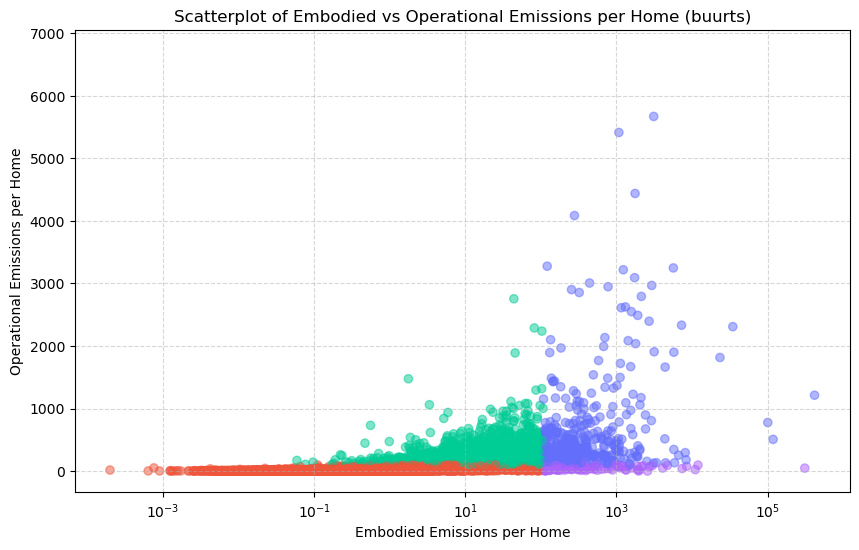

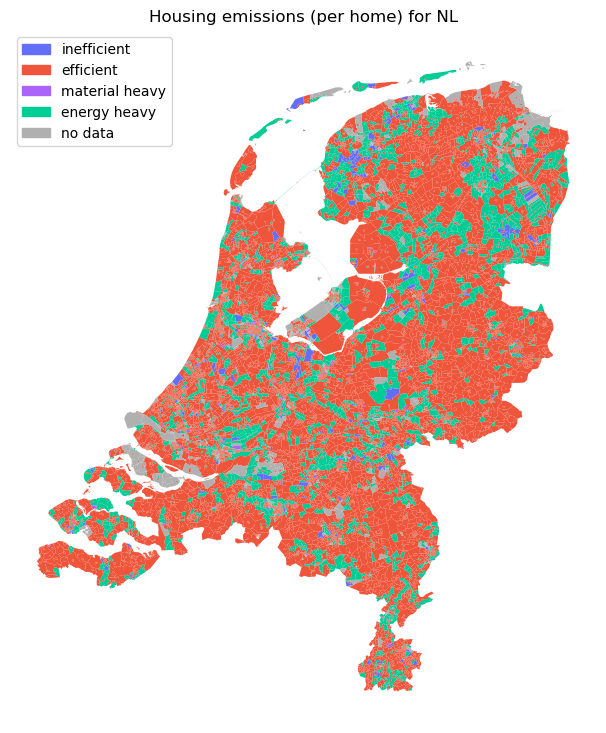

In [6]:
gdf = gdf_s3.copy()

av_operational = gdf.operational_per_home.mean()
av_embodied = gdf.embodied_per_home.mean()
def classify_buurt(row): 
    operational_col = 'operational_per_home'
    embodied_col = 'embodied_per_home'
    if pd.isna(row[operational_col]) and pd.isna(row[embodied_col]):
        return 'no data'
    elif row[operational_col] > av_operational and row[embodied_col] > av_embodied: 
        return 'inefficient'
    elif row[operational_col] > av_operational and row[embodied_col] < av_embodied:
        return 'energy heavy'
    elif row[operational_col] < av_operational and row[embodied_col] > av_embodied:
        return 'material heavy'
    elif row[operational_col] < av_operational and row[embodied_col] < av_embodied:
        return 'efficient'
    else:
        return 'no data'
gdf['buurt_type'] = gdf.apply(lambda row: classify_buurt(row), axis=1)

color_dict = {
    'inefficient': '#636EFA', 
    'efficient': '#EF553B',
    'material heavy': '#AB63FA', 
    'energy heavy': '#00CC96', 
    'no data': '#B0B0B0' 
}
gdf['color'] = gdf['buurt_type'].map(color_dict)

# scatterplot 
plt.figure(figsize=(10, 6))
plt.scatter(gdf['embodied_per_home'], gdf['operational_per_home'], c=gdf['color'], alpha=0.5)
plt.xscale('log')
plt.xlabel('Embodied Emissions per Home')
plt.ylabel('Operational Emissions per Home')
plt.title('Scatterplot of Embodied vs Operational Emissions per Home (buurts)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# map plot
fig, ax = plt.subplots(figsize=(15, 9))
gdf.plot(color=gdf['color'], legend=True, ax=ax, legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1.8, 1)})
ax.set_axis_off()
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_dict.items()]
ax.legend(handles=legend_patches, loc='upper left')
ax.set_title('Housing emissions (per home) for NL')
plt.show()

# Backup

In [ ]:
query = f''' 
WITH scenario_stats_raw AS (
	SELECT 
		municipality, bu_code, 

		-- embodied emissions stats 
		SUM(embodied_kg_s0) AS embodied_kg_s0, 
		SUM(embodied_kg_s1) AS embodied_kg_s1, 
		SUM(embodied_kg_s2) AS embodied_kg_s2, 
		SUM(embodied_kg_s3) AS embodied_kg_s3,
		SUM(embodied_kg_s1) - SUM(embodied_kg_s0) AS diff_embodied_s1, 
		SUM(embodied_kg_s2) - SUM(embodied_kg_s0) AS diff_embodied_s2, 
		SUM(embodied_kg_s3) - SUM(embodied_kg_s0) AS diff_embodied_s3,
		CASE 
			WHEN SUM(embodied_kg_s0) = 0 THEN 0
			ELSE ((SUM(embodied_kg_s1) - SUM(embodied_kg_s0)) / SUM(embodied_kg_s0)) * 100
		END AS diff_embodied_s1_pct, 
		CASE 
			WHEN SUM(embodied_kg_s0) = 0 THEN 0
			ELSE ((SUM(embodied_kg_s2) - SUM(embodied_kg_s0)) / SUM(embodied_kg_s0)) * 100
		END AS diff_embodied_s2_pct, 
		CASE 
			WHEN SUM(embodied_kg_s0) = 0 THEN 0
			ELSE ((SUM(embodied_kg_s3) - SUM(embodied_kg_s0)) / SUM(embodied_kg_s0)) * 100
		END AS diff_embodied_s3_pct,
        AVG(embodied_kg_s0 / n_homes) AS embodied_per_home,

		-- operational emissions stats 
		SUM(operational_kg_s0) AS operational_kg_s0, 
		SUM(operational_kg_s1) AS operational_kg_s1, 
		SUM(operational_kg_s2) AS operational_kg_s2, 
		SUM(operational_kg_s3) AS operational_kg_s3, 
		SUM(operational_kg_s1) - SUM(operational_kg_s0) AS diff_operational_s1, 
		SUM(operational_kg_s2) - SUM(operational_kg_s0) AS diff_operational_s2, 
		SUM(operational_kg_s3) - SUM(operational_kg_s0) AS diff_operational_s3,
		CASE 
			WHEN SUM(operational_kg_s0) = 0 THEN 0
			ELSE ((SUM(operational_kg_s1) - SUM(operational_kg_s0)) / SUM(operational_kg_s0)) * 100
		END AS diff_operational_s1_pct, 
		CASE 
			WHEN SUM(operational_kg_s0) = 0 THEN 0
			ELSE ((SUM(operational_kg_s2) - SUM(operational_kg_s0)) / SUM(operational_kg_s0)) * 100
		END AS diff_operational_s2_pct, 
		CASE 
			WHEN SUM(operational_kg_s0) = 0 THEN 0
			ELSE ((SUM(operational_kg_s3) - SUM(operational_kg_s0)) / SUM(operational_kg_s0)) * 100
		END AS diff_operational_s3_pct,
        AVG(operational_kg_s0 / n_homes) AS operational_per_home,

		-- total emissions stats 
		SUM(embodied_kg_s0) + SUM(operational_kg_s0) AS total_kg_s0, 
		SUM(embodied_kg_s1) + SUM(operational_kg_s1) AS total_kg_s1, 
		SUM(embodied_kg_s2) + SUM(operational_kg_s2) AS total_kg_s2, 
		SUM(embodied_kg_s3) + SUM(operational_kg_s3) AS total_kg_s3, 
		(SUM(embodied_kg_s1) + SUM(operational_kg_s1)) - (SUM(embodied_kg_s0) + SUM(operational_kg_s0)) AS diff_total_s1, 
		(SUM(embodied_kg_s2) + SUM(operational_kg_s2)) - (SUM(embodied_kg_s0) + SUM(operational_kg_s0)) AS diff_total_s2, 
		(SUM(embodied_kg_s3) + SUM(operational_kg_s3)) - (SUM(embodied_kg_s0) + SUM(operational_kg_s0)) AS diff_total_s3,
		CASE 
			WHEN SUM(embodied_kg_s0) + SUM(operational_kg_s0) = 0 THEN 0
			ELSE (((SUM(embodied_kg_s1) + SUM(operational_kg_s1)) - (SUM(embodied_kg_s0) + SUM(operational_kg_s0))) / (SUM(embodied_kg_s0) + SUM(operational_kg_s0))) * 100
		END AS diff_total_s1_pct, 
		CASE 
			WHEN SUM(embodied_kg_s0) + SUM(operational_kg_s0) = 0 THEN 0
			ELSE (((SUM(embodied_kg_s2) + SUM(operational_kg_s2)) - (SUM(embodied_kg_s0) + SUM(operational_kg_s0))) / (SUM(embodied_kg_s0) + SUM(operational_kg_s0))) * 100
		END AS diff_total_s2_pct, 
		CASE 
			WHEN SUM(embodied_kg_s0) + SUM(operational_kg_s0) = 0 THEN 0
			ELSE (((SUM(embodied_kg_s3) + SUM(operational_kg_s3)) - (SUM(embodied_kg_s0) + SUM(operational_kg_s0))) / (SUM(embodied_kg_s0) + SUM(operational_kg_s0))) * 100
		END AS diff_total_s3_pct,

		-- buurt stats 
		AVG(population) AS av_population, 
		AVG(population / ST_Area(bu_geom) * 1000000) AS av_population_density, 
		AVG(n_homes) AS av_n_homes, 
		AVG(woz) AS av_woz, 
		AVG(inuse / n_homes) AS av_home_size, 

		-- construction activity stats 
		AVG(construction / inuse * 100) AS av_p_construction, 
		AVG(renovation / inuse * 100) AS av_p_renovation, 
		AVG(transformation / inuse * 100) AS av_p_transformation, 
		AVG(demolition / inuse * 100) AS av_p_demolition

	FROM emissions_all_buurt_s3 
	WHERE n_homes > 0 AND population > 0 
	GROUP BY municipality, bu_code 
), 
scenario_stats AS (
	SELECT * FROM scenario_stats_raw 
    WHERE operational_kg_s0 > 0
), 
bu_geoms AS (
	SELECT "BU_CODE" AS bu_code, geometry AS bu_geom
	FROM cbs_map_2022
	WHERE "WATER" = 'NEE'
), 
scenario_stats_with_bu_geoms AS (
	SELECT 
		a.municipality, b.bu_code, b.bu_geom, 
		a.embodied_kg_s0, a.embodied_kg_s1, a.embodied_kg_s2, a.embodied_kg_s3, 
		a.diff_embodied_s1, a.diff_embodied_s2, a.diff_embodied_s3, 
		a.diff_embodied_s1_pct, a.diff_embodied_s2_pct, a.diff_embodied_s3_pct,
        a.embodied_per_home, 
		a.operational_kg_s0, a.operational_kg_s1, a.operational_kg_s2, a.operational_kg_s3, 
		a.diff_operational_s1, a.diff_operational_s2, a.diff_operational_s3, 
		a.diff_operational_s1_pct, a.diff_operational_s2_pct, a.diff_operational_s3_pct, 
        a.operational_per_home,
		a.total_kg_s0, a.total_kg_s1, a.total_kg_s2, a.total_kg_s3, 
		a.diff_total_s1, a.diff_total_s2, a.diff_total_s3, 
		a.diff_total_s1_pct, a.diff_total_s2_pct, a.diff_total_s3_pct, 
		a.av_population, a.av_n_homes, a.av_population_density, a.av_woz, a.av_home_size, 
		a.av_p_construction, a.av_p_renovation, a.av_p_transformation, a.av_p_demolition 
	FROM scenario_stats a 
	FULL JOIN bu_geoms b 
	ON a.bu_code = b.bu_code
), 

-- add n_new_homes column
scenario_stats_2012_2021 AS (
    SELECT 
        year, 
        municipality, 
        bu_code, 
        n_homes
    FROM 
        emissions_all_buurt_s3 
    WHERE 
        n_homes > 0 
        AND population > 0 
        AND (year = 2012 OR year = 2021)
),
scenario_stats_2012_2021_pivoted AS (
    SELECT
        bu_code,
        MAX(CASE WHEN year = 2012 THEN n_homes ELSE NULL END) AS n_homes_2012,
        MAX(CASE WHEN year = 2021 THEN n_homes ELSE NULL END) AS n_homes_2021
    FROM 
        scenario_stats_2012_2021
    GROUP BY 
        bu_code
), 
n_new_homes AS (
	SELECT
	    bu_code,
	    COALESCE(n_homes_2021, 0) - COALESCE(n_homes_2012, 0) AS n_new_homes
	FROM
	    scenario_stats_2012_2021_pivoted
)

SELECT a.*, b.n_new_homes
FROM scenario_stats_with_bu_geoms a 
LEFT JOIN n_new_homes b 
ON a.bu_code = b.bu_code 
'''

gdf_s3 = gpd.read_postgis(query, engine, geom_col='bu_geom')